In [1]:
import json
import numpy as np
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow import keras
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from collections import Counter

### Read Data


In [2]:
with open(r'../data/json/closure.json', encoding='utf8', mode='r') as f:
    data = json.load(f)


### Extract Data Feature


In [6]:
All_data = []
All_keys = []
for i in data.keys():
    temp = []
    for j in data[i].keys():
        try:
            for k in data[i][j].keys():
                if j+"_"+k not in All_keys:
                    All_keys.append(j+"_"+k)
            for x in data[i][j].values():
                temp.append(x)
        except AttributeError:
            temp.append(data[i][j])
            if j not in All_keys:
                    All_keys.append(j)
    All_data.append(temp)
All_data = np.array(All_data)
All_keys = np.array(All_keys)
All_data.shape

(100, 109)

In [3]:
CognitiveData_Cold = []
CognitiveData_Hot = []
CognitiveData = []
for i in data.keys():
    temp = list(data[i]['cognitiveData_Cold'].values())
    temp_hot = list(data[i]['cognitiveData_Hot'].values())
    CognitiveData_Cold.append(temp)
    CognitiveData_Hot.append(temp_hot)
    temp.extend(temp_hot)
    CognitiveData.append(temp)
CognitiveData_Cold = np.array(CognitiveData_Cold)
CognitiveData_Hot = np.array(CognitiveData_Hot)
CognitiveData = np.array(CognitiveData)
CognitiveData.shape


(100, 14)

### Model


##### Kmeans

In [5]:
kmeans_CognitiveData_Cold = KMeans(n_clusters=2, random_state=0).fit(CognitiveData_Cold)
kmeans_CognitiveData_Hot = KMeans(n_clusters=2, random_state=0).fit(CognitiveData_Hot)
kmeans_CognitiveData = KMeans(n_clusters=2, random_state=0).fit(CognitiveData)

In [6]:
CognitiveData_Cold[:, 1].shape

(100,)

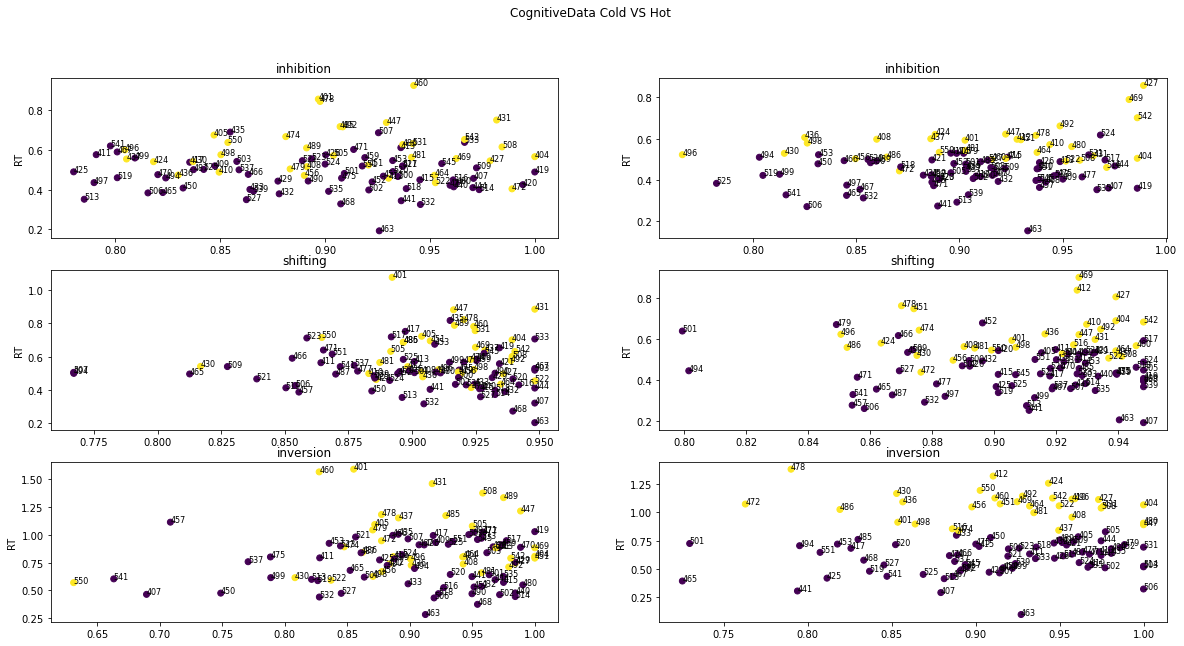

In [7]:
title = ['inhibition', 'shifting', 'inversion']
index = [x for x in data.keys()]
plt.figure(figsize=(20, 10))
plt.suptitle("CognitiveData Cold VS Hot")
for i in range(0, 6, 2):
    plt.subplot(3, 2, i+1)
    plt.title(title[int((i+1)/2)])
    plt.ylabel("RT")
    plt.scatter(CognitiveData_Cold[:, i], CognitiveData_Cold[:,i+1], c = kmeans_CognitiveData_Cold.labels_)
    for j in range(len(index)):
        plt.annotate(index[j], xy = (CognitiveData_Cold[:, i][j],CognitiveData_Cold[:,i+1][j]), size=8 )
    plt.subplot(3, 2, i+2)
    plt.title(title[int((i+1)/2)])
    plt.ylabel("RT")
    plt.scatter(CognitiveData_Hot[:, i], CognitiveData_Hot[:,i+1], c = kmeans_CognitiveData_Hot.labels_)
    for j in range(len(index)):
        plt.annotate(index[j], xy = (CognitiveData_Hot[:, i][j], CognitiveData_Hot[:,i+1][j]), size=8 )


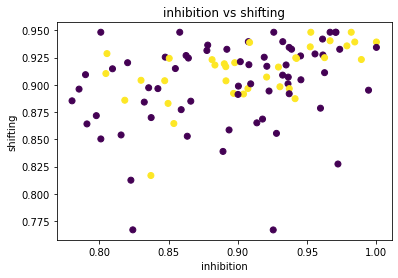

In [8]:
plt.title("inhibition vs shifting")
plt.xlabel("inhibition")
plt.ylabel("shifting")
plt.scatter(CognitiveData_Cold[:, 0], CognitiveData_Cold[:,
            2], c=kmeans_CognitiveData_Cold.labels_)


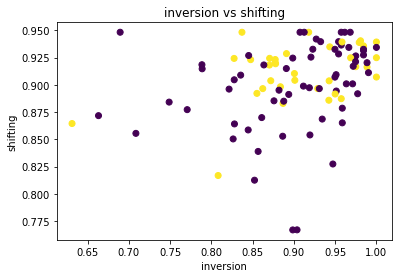

In [9]:
plt.title("inversion vs shifting")
plt.xlabel("inversion")
plt.ylabel("shifting")
plt.scatter(CognitiveData_Cold[:, 4], CognitiveData_Cold[:,2], c=kmeans_CognitiveData_Cold.labels_)


##### Correlation Coefficient Matrix

In [10]:
temp = All_data[:,:15]
# label = [x for x in data["401"]['cognitiveData_Cold'].keys()]*2 + ["VAS_Pre_Cold"]
plt.suptitle("CognitiveData_Cold * Hot Correlation Coefficient Matrix")
sns.heatmap(np.corrcoef(temp.T), xticklabels = All_keys[:15], yticklabels = All_keys[:15])

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> None

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.suptitle("All Correlation Coefficient Matrix")
sns.heatmap(np.corrcoef(All_data.T))

In [ ]:
sns.heatmap(np.corrcoef(All_data[:,34:45].T), xticklabels = All_keys[34:45], yticklabels = All_keys[34:45])

##### PIE

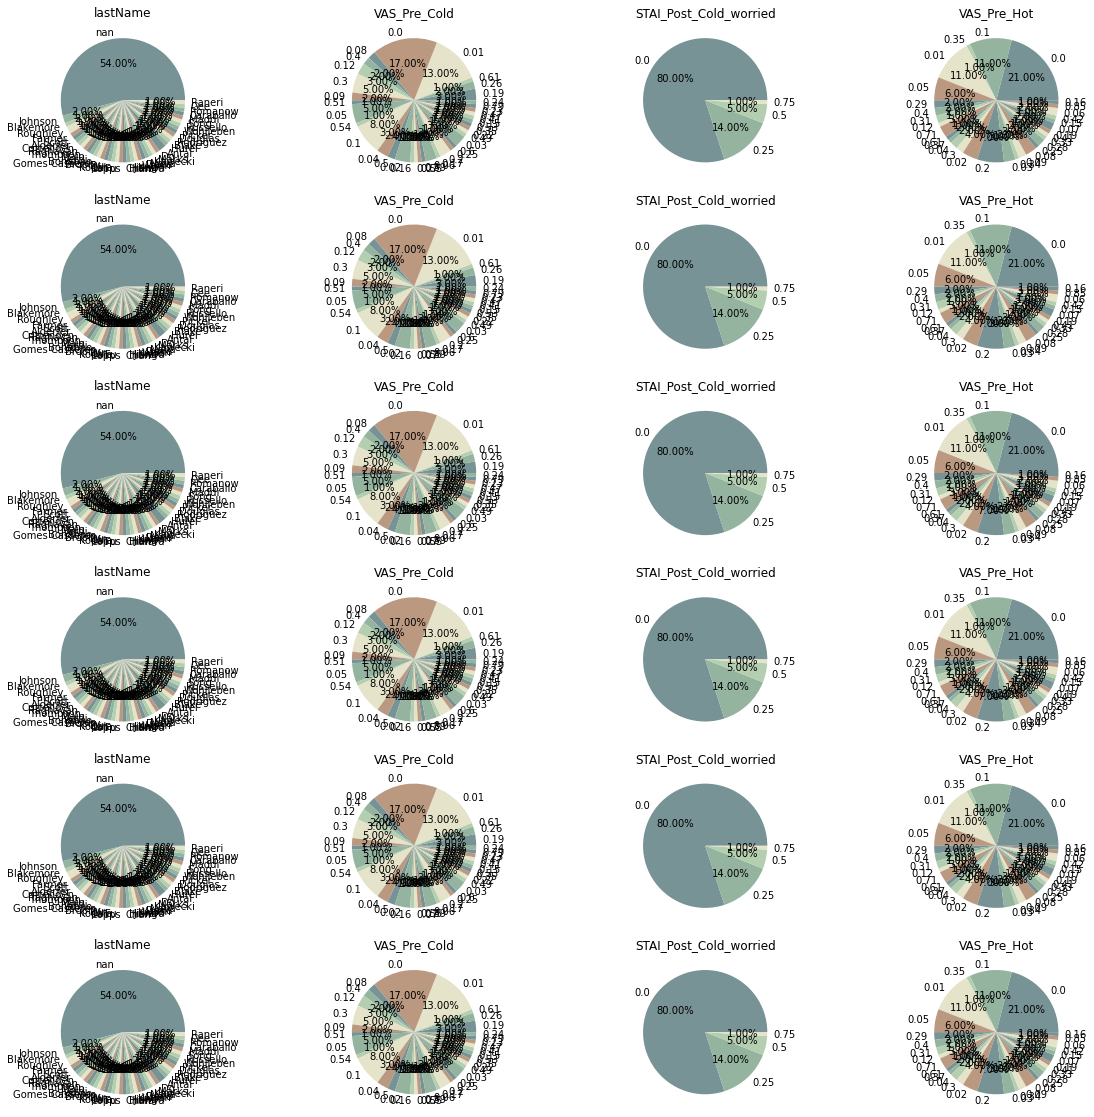

In [11]:
def draw_pie(bias,i,pos,cmap):
    plt.subplot(6,4,i*4+pos)
    plt.title(All_keys[15+bias])
    plt.pie(Counter(All_data[:,15+bias]).values(),
    labels = Counter(All_data[:,15+bias]).keys(),
    autopct='%.2f%%',
    colors = ["#789395","#94B49F","#B4CFB0","#E5E3C9","#BB9981"])

temp_bias = [0, 11, 11+17, 11*2+17]
plt.figure(figsize=(20,20))
cmap = mpl.cm.cool
for i in range(6):
    for j in range(4):
        draw_pie(temp_bias[j],i,j+1,cmap)
plt.show()

##### (memory_cold-memory_hot / [(VAS_post_cold - VAS_pre_cold) - (VAS_post_hot - VAS_pre_hot)])

In [12]:
dif_memory = All_data[:,6]-All_data[:,7]
dif_VAS = (All_data[:,14]-All_data[:,14+11]) - (All_data[:,14+11+17]-All_data[:,14+11+17+11])
plt.plot(dif_memory)
plt.plot(dif_VAS)
plt.legend(["dif_memory","dif_VAS"])

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> None

In [ ]:
plt.scatter(dif_memory,dif_VAS)
plt.xlabel("dif_memory")
plt.ylabel("dif_VAS")

### ML Methods

##### Construct Data

In [ ]:
all_cold_data = All_data[:,0:7]
# all_cold_data = np.hstack((all_cold_data,All_data[:,14:70-28]))
all_hot_data = All_data[:,7:14]
# all_hot_data = np.hstack((all_hot_data,All_data[:,70-28:]))
all_cold_data.shape

In [ ]:
label_hot = np.ones(103)
label_cold = np.zeros(103)
label = np.hstack((label_cold,label_hot))
label_nn = keras.utils.to_categorical(label)
label.shape

In [ ]:
X = np.vstack((all_cold_data, all_hot_data))
y = np.hstack((label_cold, label_hot))
# X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X,label_nn,shuffle=True)

##### LR

In [ ]:
# ALL feature
kf = KFold(n_splits=10)
i = 0
for train_index, test_index in kf.split(X_train):
    model_LR = LogisticRegression().fit(X_train[train_index],y_train[train_index])
    print("acc"+str(i)+":",model_LR.score(X_train[test_index],y_train[test_index]))
    i += 1
print("acc_test:",model_LR.score(X_test, y_test))

In [ ]:
# Cognitive
kf = KFold(n_splits=10)
i = 0
for train_index, test_index in kf.split(X_train):
    model_LR = LogisticRegression(penalty="l2").fit(X_train[train_index],y_train[train_index])
    print("acc"+str(i)+":",model_LR.score(X_train[test_index],y_train[test_index]))
    i += 1
print("acc_test:",model_LR.score(X_test, y_test))

##### SVC

In [ ]:
# ALL feature
kf = KFold(n_splits=10)
i = 0
for train_index, test_index in kf.split(X_train):
    model_SVM = SVC(kernel="linear").fit(X_train[train_index],y_train[train_index])
    print("acc"+str(i)+":",model_SVM.score(X_train[test_index],y_train[test_index]))
    i += 1
print("acc_test:",model_SVM.score(X_test, y_test))

In [ ]:
# Cognitive
kf = KFold(n_splits=10)
i = 0
for train_index, test_index in kf.split(X_train):
    model_SVM = SVC(kernel="rbf").fit(X_train[train_index],y_train[train_index])
    print("acc"+str(i)+":",model_SVM.score(X_train[test_index],y_train[test_index]))
    i += 1
print("acc_test:",model_SVM.score(X_test, y_test))

##### DNN

In [ ]:
# ALL_data
model = Sequential()
model.add(Dense(32,activation="relu"))
model.add(Dense(2,activation="sigmoid"))

model.compile(loss = keras.losses.categorical_crossentropy,
                optimizer='sgd',
                metrics=["accuracy"])

history = model.fit(X_train,y_train,batch_size=3,epochs=100,verbose=1,validation_data=(X_test,y_test))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc','val_acc'])
plt.show()

In [ ]:
# Cognitive
model = Sequential()
model.add(Dense(32,activation="relu"))
model.add(Dense(2,activation="sigmoid"))

model.compile(loss = keras.losses.categorical_crossentropy,
                optimizer='sgd',
                metrics=["accuracy"])

history = model.fit(X_train,y_train,batch_size=3,epochs=100,verbose=1,validation_data=(X_test,y_test))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc','val_acc'])
plt.show()